In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install opencv-python

In [ ]:
!pip install mediapipe==0.10.1

In [ ]:
!pip install cvzone

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
import numpy as np
from numpy import concatenate
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
import cv2
import sys

from IPython.display import SVG

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import load_model
from keras.layers import Activation, Convolution2D, Dropout, Conv2D, Dense, ZeroPadding2D, ReLU
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
import keras
from keras import models

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/face recognition/fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
# emotion_labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
# 샘플 불규형을 해소하기 위해 (angry, disgust) 감정은 하나의 라벨로 통합
df['emotion'] = df['emotion'].map({0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5})
# 0 : angry or disgust, 1 : fear, 2 : happy, 3: sad, 4 : surprise, 5 : neutral 로 변경

In [ ]:
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,1,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,5,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,5,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,2,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,2,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
image_size = (48, 48)
pixels = df['pixels'].tolist()
width, height = 48, 48
faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'), image_size)
    faces.append(face.astype('float32'))

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)

In [ ]:
faces.shape

(35887, 48, 48, 1)

In [ ]:
x = faces.astype('float32')
x = x / 255.0

x = x - 0.5
x = x * 2.0

num_samples = x.shape[0]
print(num_samples)

35887


In [ ]:
r_faces = []
for i in range(len(faces)):
    r_faces.append(cv2.resize(faces[i], (150, 150), interpolation=cv2.INTER_LINEAR))
r_faces = np.asarray(r_faces)
repeat_r_faces = np.repeat(r_faces[:, :, :, np.newaxis], 3, axis=3)

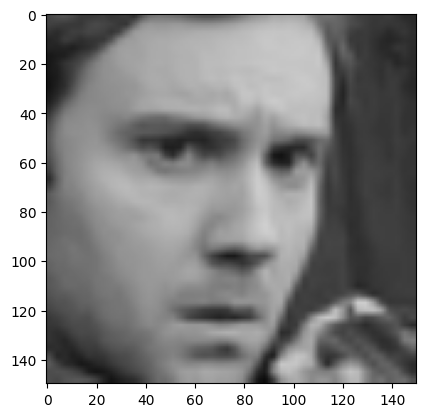

In [ ]:
plt.imshow(repeat_r_faces[0].astype(int))
plt.show()

In [ ]:
r_x = repeat_r_faces.astype('float32')
r_x = r_x / 255.0

r_x = r_x - 0.5
r_x = r_x * 2.0

In [ ]:
emotions = pd.get_dummies(df[['emotion']], columns=['emotion'])
emotions

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
35882,0,0,0,0,0,1
35883,0,0,1,0,0,0
35884,1,0,0,0,0,0
35885,0,0,1,0,0,0


In [ ]:
num_samples, num_classes = emotions.shape
num_train_samples = int(0.8 * num_samples)

x_train = x[:num_train_samples]
y_train = emotions[:num_train_samples]

# val
x_val = x[num_train_samples:]
y_val = emotions[num_train_samples:]

train_data = (x_train, y_train)
val_data = (x_val, y_val)

In [ ]:
r_x_train = r_x[:num_train_samples]
r_x_val = r_x[num_train_samples:]
r_train_data = (r_x_train, y_train)
r_val_data = (r_x_val, y_val)

In [ ]:
print('x_train shape : ', x_train.shape)
print('x_val shape : ', x_val.shape)
print('y_train shape : ', y_train.shape)
print('y_val shape : ', y_val.shape)

x_train shape :  (28709, 48, 48, 1)
x_val shape :  (7178, 48, 48, 1)
y_train shape :  (28709, 6)
y_val shape :  (7178, 6)


In [ ]:
print('x_train shape : ', r_x_train.shape)
print('x_val shape : ', r_x_val.shape)
print('y_train shape : ', y_train.shape)
print('y_val shape : ', y_val.shape)

x_train shape :  (28709, 150, 150, 3)
x_val shape :  (7178, 150, 150, 3)
y_train shape :  (28709, 6)
y_val shape :  (7178, 6)


## 모델 구성

In [ ]:
!pip install wget

In [ ]:
# InceptionV3

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
import wget

url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
wget.download(url)
weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), include_top=False, weights=None)

In [ ]:
pre_trained_model.load_weights(weights_file)

In [ ]:
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape : ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape :  (None, 7, 7, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
batch_size=32
num_epochs=40

data_generator = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

keras.backend.clear_session()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

r_train_faces, r_train_emotions = r_train_data
history = model.fit(data_generator.flow(r_train_faces, r_train_emotions, batch_size),
                             epochs=num_epochs, verbose=1, validation_data=r_val_data)

Epoch 1/40
898/898 [==============================] - 143s 155ms/step - loss: 1.2481 - accuracy: 0.5191 - val_loss: 1.1411 - val_accuracy: 0.5614
Epoch 2/40
898/898 [==============================] - 138s 154ms/step - loss: 1.1958 - accuracy: 0.5402 - val_loss: 1.1562 - val_accuracy: 0.5566
Epoch 3/40
898/898 [==============================] - 139s 155ms/step - loss: 1.1708 - accuracy: 0.5517 - val_loss: 1.0912 - val_accuracy: 0.5786
Epoch 4/40
898/898 [==============================] - 138s 153ms/step - loss: 1.1391 - accuracy: 0.5624 - val_loss: 1.0900 - val_accuracy: 0.5860
Epoch 5/40
898/898 [==============================] - 138s 154ms/step - loss: 1.1224 - accuracy: 0.5727 - val_loss: 1.0952 - val_accuracy: 0.5795
Epoch 6/40
898/898 [==============================] - 138s 154ms/step - loss: 1.1090 - accuracy: 0.5761 - val_loss: 1.0606 - val_accuracy: 0.5939
Epoch 7/40
898/898 [==============================] - 137s 153ms/step - loss: 1.0869 - accuracy: 0.5858 - val_loss: 1.0654 -

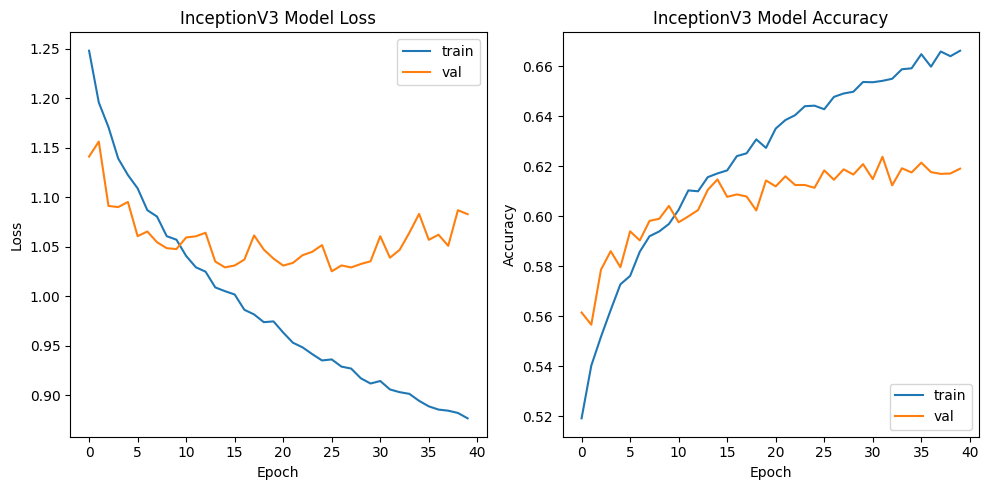

In [ ]:
plt.figure(figsize=(10, 5))

# 손실 그래프
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('InceptionV3 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(r_x_val)

print(classification_report(np.argmax(np.array(y_val), axis=1), np.argmax(y_pred, axis=1)))

225/225 [==============================] - 6s 23ms/step
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      1069
           1       0.49      0.42      0.45      1024
           2       0.74      0.88      0.80      1774
           3       0.50      0.43      0.47      1247
           4       0.77      0.72      0.74       831
           5       0.58      0.59      0.58      1233

    accuracy                           0.62      7178
   macro avg       0.60      0.60      0.60      7178
weighted avg       0.61      0.62      0.61      7178



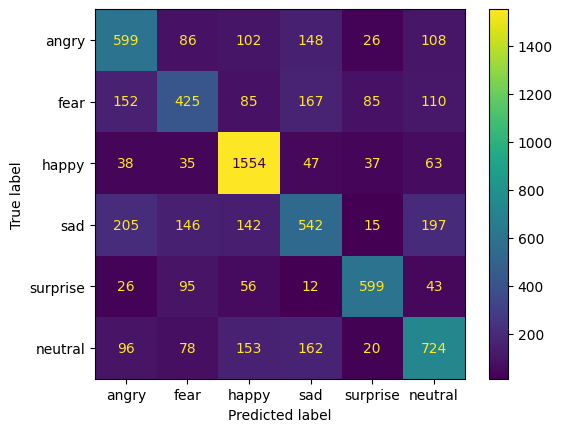

In [ ]:
# 0 : angry/disgust, 1 : fear, 2 : happy, 3 : sad, 4 : surprise, 5 : neutral
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf = confusion_matrix(np.argmax(np.array(y_val), axis=1), np.argmax(y_pred, axis=1))

cm_display = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels = ['angry', 'fear', 'happy', 'sad','surprise', 'neutral'])
cm_display.plot()

In [ ]:
model.save('emotion_model_InceptionV3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# ResNet50

def identity_block(X, f, filters):
    F1, F2, F3 = filters

    X_shortcut = X

    # First layer
    X = Conv2D(filters = F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second layer
    X = Conv2D(filters = F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third layer
    X = Conv2D(filters = F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)

    # Final step : Add shortcut value to F(X), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolution_block(X, f, filters, s=2):

    F1, F2, F3 = filters

    X_shortcut = X

    # First layer
    X = Conv2D(F1, (1, 1), strides = (s, s))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second layer
    X = Conv2D(filters = F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third layer
    X = Conv2D(filters = F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)

    # SHORTCUT PATH
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Final step : Add shortcut value , pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape=(48, 48, 1), classes=6):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # stage 2
    X = convolution_block(X, f=3, filters=[64, 64, 256], s=1)

    X = identity_block(X, 3, [64, 64, 256])

    X = identity_block(X, 3, [64, 64, 256])

    # stage 3
    X = convolution_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # stage 4
    X = convolution_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # stage 5
    X = convolution_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc'+str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # create model
    model = Model(inputs = X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape=(48, 48, 1), classes=6)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 54, 54, 1)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 24, 24, 64)           3200      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 24, 24, 64)           256       ['conv2d[0][0]']       

In [ ]:
batch_size=32
num_epochs=80
num_classes=6

data_generator = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

keras.backend.clear_session()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_faces, train_emotions = train_data
history = model.fit(data_generator.flow(train_faces, train_emotions, batch_size),
                             epochs=80, verbose=1, validation_data=val_data)

In [ ]:
plt.figure(figsize=(10, 5))

# 손실 그래프
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_val)

print(classification_report(np.argmax(np.array(y_val), axis=1), np.argmax(y_pred, axis=1)))

In [ ]:
# 0 : angry/disgust, 1 : fear, 2 : happy, 3 : sad, 4 : surprise, 5 : neutral
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf = confusion_matrix(np.argmax(np.array(y_val), axis=1), np.argmax(y_pred, axis=1))

cm_display = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels = ['angry', 'fear', 'happy', 'sad','surprise', 'neutral'])
cm_display.plot()

In [ ]:
model.save('emotion_model_ResNet50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Self_CNN_1

input_shape = (48, 48, 1)
num_classes = 6

model = Sequential()
model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', input_shape=input_shape))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# Self_CNN_2

input_shape = (48, 48, 1)
num_classes = 6

model = Sequential()
model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same', name='image_array', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(filters=num_classes, kernel_size=(3,3), padding='same'))
model.add(GlobalAveragePooling2D())

model.add(Activation('softmax', name='predictions'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 16)        800       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        12560     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 16)        64        
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 48, 48, 16)        0         
                                                                 
 average_pooling2d (Average  (None, 24, 24, 16)        0

In [ ]:
batch_size=32
num_epochs=80
num_classes=6

data_generator = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

In [ ]:
import keras

In [ ]:
keras.backend.clear_session()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_faces, train_emotions = train_data
history = model.fit(data_generator.flow(train_faces, train_emotions, batch_size),
                             epochs=80, verbose=1, validation_data=val_data)

Epoch 1/80
898/898 [==============================] - 23s 16ms/step - loss: 1.7528 - accuracy: 0.2516 - val_loss: 1.5934 - val_accuracy: 0.3011
Epoch 2/80
898/898 [==============================] - 14s 15ms/step - loss: 1.6532 - accuracy: 0.2841 - val_loss: 1.5110 - val_accuracy: 0.3665
Epoch 3/80
898/898 [==============================] - 13s 15ms/step - loss: 1.5978 - accuracy: 0.3170 - val_loss: 1.4374 - val_accuracy: 0.4195
Epoch 4/80
898/898 [==============================] - 13s 15ms/step - loss: 1.5649 - accuracy: 0.3346 - val_loss: 1.3970 - val_accuracy: 0.4387
Epoch 5/80
898/898 [==============================] - 13s 15ms/step - loss: 1.5343 - accuracy: 0.3562 - val_loss: 1.3950 - val_accuracy: 0.4302
Epoch 6/80
898/898 [==============================] - 14s 16ms/step - loss: 1.5141 - accuracy: 0.3658 - val_loss: 1.3898 - val_accuracy: 0.4248
Epoch 7/80
898/898 [==============================] - 14s 15ms/step - loss: 1.4992 - accuracy: 0.3692 - val_loss: 1.3623 - val_accuracy:

In [ ]:
from sklearn.metrics import classification_report

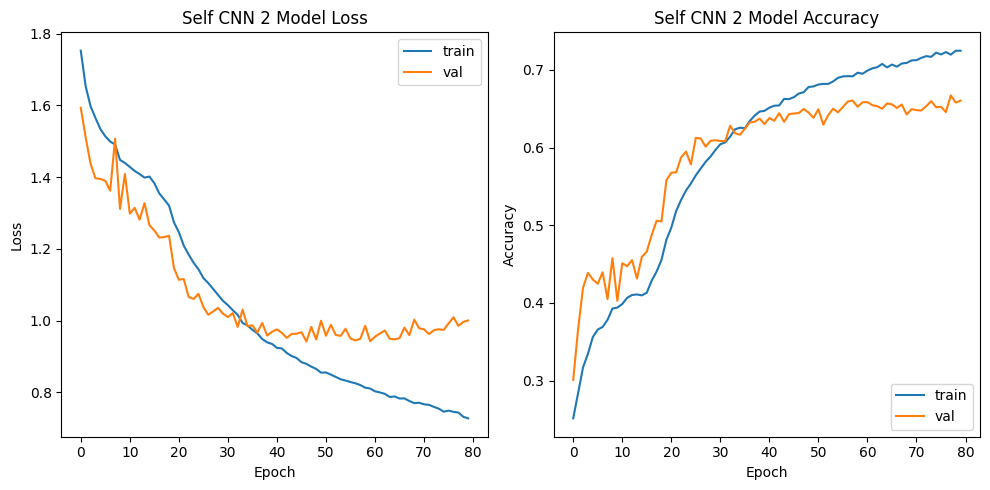

In [ ]:
plt.figure(figsize=(10, 5))

# 손실 그래프
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Self CNN 2 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Self CNN 2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(x_val)

print(classification_report(np.argmax(np.array(y_val), axis=1), np.argmax(y_pred, axis=1)))

225/225 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.59      0.67      0.62      1069
           1       0.50      0.45      0.47      1024
           2       0.85      0.87      0.86      1774
           3       0.57      0.43      0.49      1247
           4       0.80      0.76      0.78       831
           5       0.57      0.68      0.62      1233

    accuracy                           0.66      7178
   macro avg       0.65      0.64      0.64      7178
weighted avg       0.66      0.66      0.66      7178



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

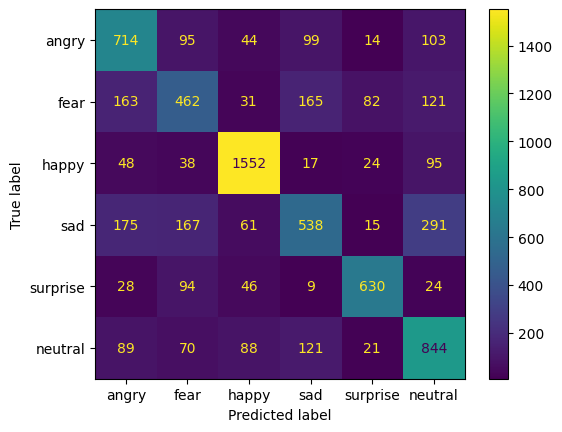

In [ ]:
# 0 : angry/disgust, 1 : fear, 2 : happy, 3 : sad, 4 : surprise, 5 : neutral
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(np.argmax(np.array(y_val), axis=1), np.argmax(y_pred, axis=1))

cm_display = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels = ['angry', 'fear', 'happy', 'sad','surprise', 'neutral'])
cm_display.plot()

In [ ]:
model.save('emotion_model_selfCNN_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# MLP
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_array (Conv2D)        (None, 48, 48, 16)        800       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        12560     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 16)        64        
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 48, 48, 16)        0         
                                                                 
 average_pooling2d (Average  (None, 24, 24, 16)        0

In [ ]:
batch_size=32
num_epochs=80
num_classes=6

data_generator = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

In [ ]:
keras.backend.clear_session()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_faces, train_emotions = train_data
history = model.fit(data_generator.flow(train_faces, train_emotions, batch_size),
                             epochs=80, verbose=1, validation_data=val_data)

Epoch 1/80
898/898 [==============================] - 23s 18ms/step - loss: 1.7367 - accuracy: 0.2798 - val_loss: 1.6978 - val_accuracy: 0.3292
Epoch 2/80
898/898 [==============================] - 14s 16ms/step - loss: 1.5735 - accuracy: 0.3671 - val_loss: 1.4673 - val_accuracy: 0.4235
Epoch 3/80
898/898 [==============================] - 15s 16ms/step - loss: 1.4890 - accuracy: 0.4054 - val_loss: 1.3854 - val_accuracy: 0.4461
Epoch 4/80
898/898 [==============================] - 14s 16ms/step - loss: 1.4124 - accuracy: 0.4422 - val_loss: 1.3705 - val_accuracy: 0.4629
Epoch 5/80
898/898 [==============================] - 14s 16ms/step - loss: 1.3571 - accuracy: 0.4647 - val_loss: 1.2816 - val_accuracy: 0.4929
Epoch 6/80
898/898 [==============================] - 14s 16ms/step - loss: 1.3236 - accuracy: 0.4818 - val_loss: 1.3018 - val_accuracy: 0.4893
Epoch 7/80
898/898 [==============================] - 14s 16ms/step - loss: 1.2948 - accuracy: 0.4940 - val_loss: 1.2033 - val_accuracy:

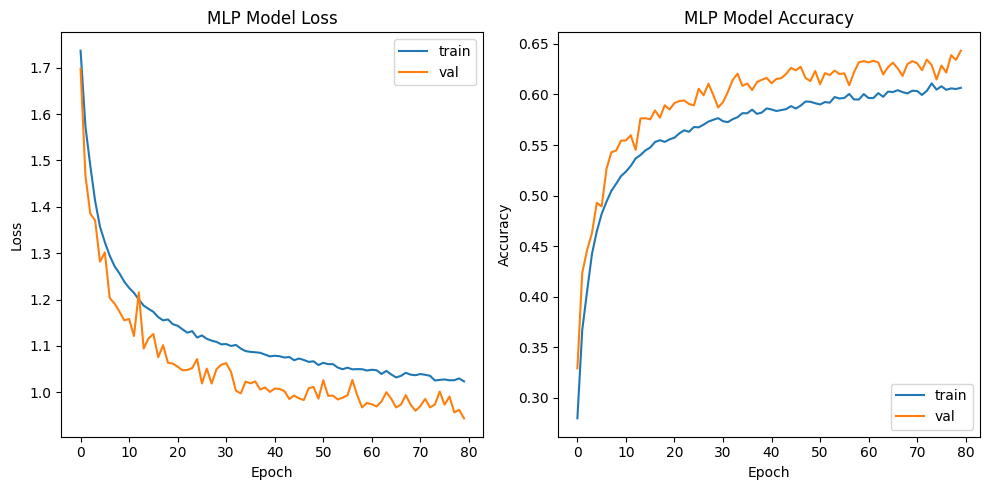

In [ ]:
plt.figure(figsize=(10, 5))

# 손실 그래프
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MLP Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MLP Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(x_val)

print(classification_report(np.argmax(np.array(y_val), axis=1), np.argmax(y_pred, axis=1)))

225/225 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.58      0.65      0.61      1069
           1       0.52      0.30      0.38      1024
           2       0.86      0.85      0.85      1774
           3       0.53      0.49      0.51      1247
           4       0.70      0.82      0.75       831
           5       0.54      0.66      0.60      1233

    accuracy                           0.64      7178
   macro avg       0.62      0.63      0.62      7178
weighted avg       0.64      0.64      0.63      7178



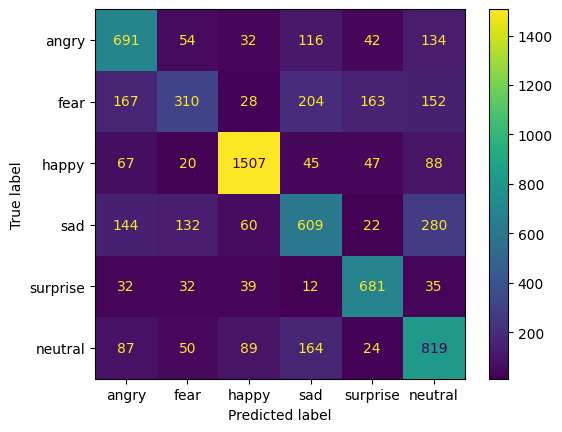

In [ ]:
# 0 : angry/disgust, 1 : fear, 2 : happy, 3 : sad, 4 : surprise, 5 : neutral
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(np.argmax(np.array(y_val), axis=1), np.argmax(y_pred, axis=1))

cm_display = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels = ['angry', 'fear', 'happy', 'sad','surprise', 'neutral'])
cm_display.plot()

In [ ]:
model.save('emotion_model_selfCNN2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
